In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.lines as mlines
import re
from collections import Counter

In [2]:
df = pd.read_csv("../../1_annotation_tools/data/datasets_to_check/combined_datasets/combined_datasets.csv").fillna("")

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [4]:
def normalize_book(name: str) -> str:
    if any(name.startswith(prefix) for prefix in ["1_Samuel", "2_Samuel"]):
        return "Samuel"
    elif any(name.startswith(prefix) for prefix in ["1_Kings", "2_Kings"]):
        return "Kings"
    elif any(name.startswith(prefix) for prefix in ["1_Chronicles", "2_Chronicles"]):
        return "Chronicles"
    else:
        return name

df["book2"] = df["book"].apply(normalize_book)

In [5]:
# Create a book_scroll column
df['book_scroll'] = df['book2'] + "_" + df['scroll']

In [6]:
#set(df.book_scroll)

In [7]:
#set(df.book2)

In [8]:
set(df.cmpl_constr)

{'', 'dir-he', 'prep', 'prep + dir-he', 'vc'}

In [9]:
exclude_comments = ["min excluded", "reconstructed", "verb rec"]
motion_type = ["factive", "fictive"]

df_goals = df[~df['comments'].isin(exclude_comments)].copy()
df_goals = df_goals[df_goals['spatial_arg_type'] == "goal"].copy()
df_goals = df_goals[df_goals['motion_type'].isin(motion_type)].copy()

In [10]:
df_goals['cmpl_constr'] = df_goals['cmpl_constr'].replace("vc", "unmarked")

In [11]:
print(set(df_goals.motion_type))
print(set(df_goals.spatial_arg_type))
print(set(df_goals.cmpl_constr))

{'fictive', 'factive'}
{'goal'}
{'prep + dir-he', 'unmarked', 'dir-he', 'prep'}


In [12]:
#set(df_goals.comments)

## Part 1: select an example dataframe

In [13]:
# Overall counts
lex_counts = df_goals['lex'].value_counts().reset_index()
lex_counts.columns = ['lex', 'count']

# Show top 10
print(lex_counts.head(10))

    lex  count
0  BW>[   1734
1  <LH[    411
2  CWB[    403
3  HLK[    362
4  JY>[    236
5  JRD[    198
6  QRB[    163
7  <BR[    102
8  NGC[     73
9  NWS[     48


In [14]:
# Overall counts
constr_counts = df_goals['cmpl_constr'].value_counts().reset_index()
constr_counts.columns = ['cmpl_constr', 'count']

# Show top 10
print(constr_counts.head(10))

     cmpl_constr  count
0           prep   2966
1       unmarked    619
2         dir-he    413
3  prep + dir-he      7


In [15]:
#Counter(df_goals.cmpl_lex[(df_goals.lex == "<LH[") & (df_goals.cmpl_constr == "prep")])

In [16]:
# Save the 5 most frequent verbs in a list
freq_verbs = lex_counts.head(5)['lex'].to_list()

In [23]:
# Filter a dataframe with only the 5 most frequent verbs
#df_top5 = df_goals[df_goals['lex'].isin(freq_verbs)]
# For Jorik
df_top5 = df_goals

In [43]:
# Select books for example

# Count total occurrences of all top5 verbs per book_scroll
book_totals = (
    df_top5.groupby('book_scroll')
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

# Take the top 20
top50_books = book_totals.head(50)

print(top50_books)

           book_scroll  count
129          Samuel_MT    466
86            Kings_MT    378
60          Genesis_MT    316
5        Chronicles_MT    289
71         Jeremiah_MT    286
108         Numbers_MT    196
53          Ezekiel_MT    184
82           Judges_MT    182
81           Joshua_MT    173
27      Deuteronomy_MT    167
46           Exodus_MT    164
120          Psalms_MT    132
67           Isaiah_MT    131
95        Leviticus_MT    128
66       Isaiah_1Qisaa    126
72              Job_MT     48
6            Daniel_MT     36
105        Nehemiah_MT     36
31           Esther_MT     32
56             Ezra_MT     29
1              1QM_1QM     29
112        Proverbs_MT     27
65          Isaiah_1Q8     25
2              1QS_1QS     24
64            Hosea_MT     21
124            Ruth_MT     20
3              Amos_MT     20
126        Samuel_4Q51     17
132       Zechariah_MT     17
100           Micah_MT     16
0              1QH_1QH     16
77            Jonah_MT     13
88     Lam

In [44]:
# Select one Qumran sectarian scroll for example
qumran_scrolls = ["1QH_1QH", "1QM_1QM", "1QS_1QS"]

qumran_counts = (
    df_top5[df_top5['book_scroll'].isin(qumran_scrolls)]
    .groupby('book_scroll')
    .size()
    .reset_index(name='count')
)

print(qumran_counts)

  book_scroll  count
0     1QH_1QH     16
1     1QM_1QM     29
2     1QS_1QS     24


## Part 2: Visualize goal markings in the different books - Selected Books

In [45]:
# 1) Aggregate & normalize (exclude "prep + dir-he")
dfx = (
    df_top5.loc[df_top5["cmpl_constr"].ne("prep + dir-he")]
    .dropna(subset=["lex","book_scroll","cmpl_constr"])
)

In [46]:
#set(dfx.lex)

In [47]:
# Example mapping (fill in with your real Hebrew forms)
lex_to_hebrew = {
    "BW>[": "בוא",
    "HLK[": "הלך",
    "JY>[": "יצא",
    "JRD[": "ירד",
    "<BR[": "עבר",
    "<LH[": "עלה",
    "CWB[": "שוב",
    ">TH[": "אתה",
    "BRX[": "ברח",
    "GJX[": "גיח",
    "GLH[": "גלה",
    "GLL[": "גלל",
    "DXP[": "דחף",
    "DLG[": "דלג",
    "HWH=[": "הוה",
    "XWC[": "חוש",
    "XLP[": "ח‌לף",
    "XSH[": "חסה",
    "VB<[": "טבע",
    "VWF[": "טוש",
    "MHR[": "מהר",
    "MWC[": "מוש",
    "NGC[": "נגש",
    "NHR[": "נהר",
    "NWX[": "נוח",
    "NWS[": "נוס",
    "NXT[": "נחת",
    "NVP[": "נטף",
    "NS<[": "נסע",
    "NPL[": "נפל",
    "NTK[": "נתך",
    "SBB[": "סבב",
    "SWR[": "סור",
    "SLQ[": "סלק",
    "<WZ[": "עוז",
    "<WP[": "עוף",
    "PNH[": "פנה",
    "PF<[": "פשע",
    "YWP[": "צוּף",
    "Y<D[": "צע͏ד",
    "QHL[": "קהל",
    "QPY[": "קפץ",
    "QRB[": "קרב",
    "RWY[": "רוץ",
    "FVH[": "שטה",
    "CWX[": "שוח",
    "CWR=[": "שור",
    "CVP[": "שטף",
    "CQQ[": "שקק",
    "T>R[": "תאר",
    "T<H[": "תעה",
}

In [48]:
len(set(dfx.book_scroll))

135

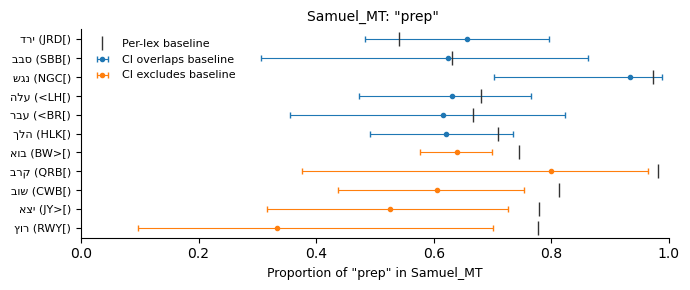

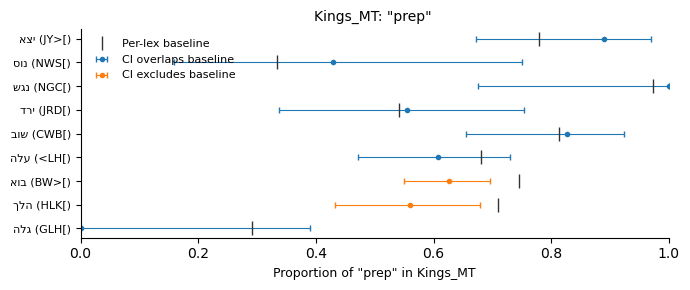

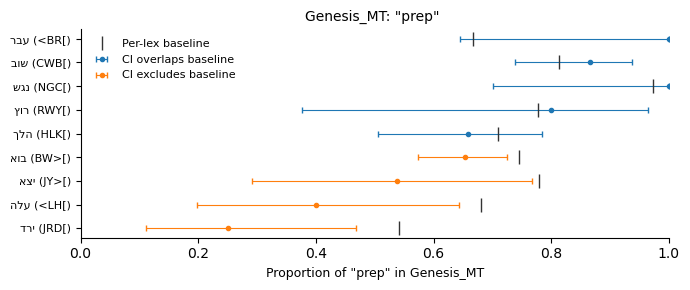

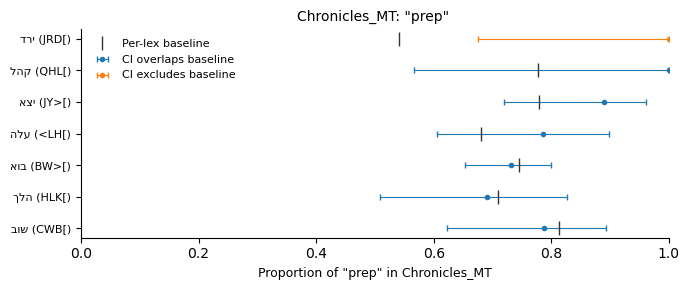

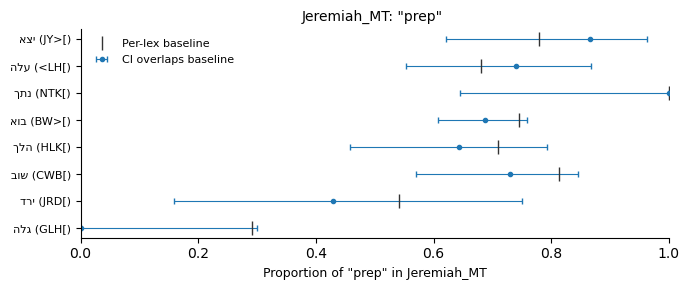

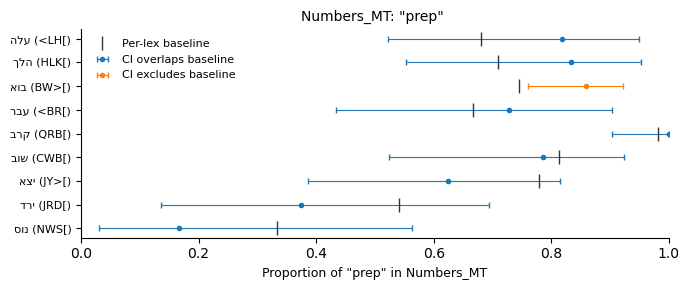

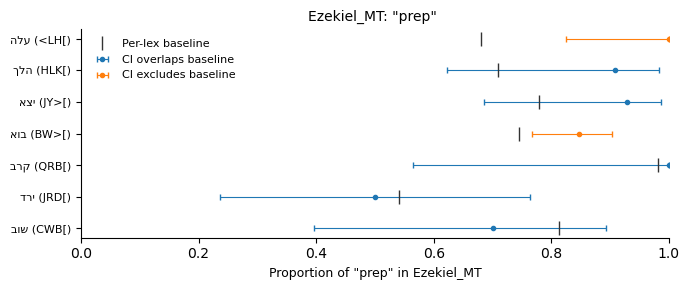

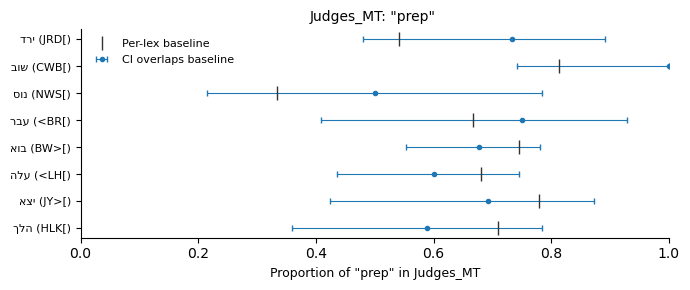

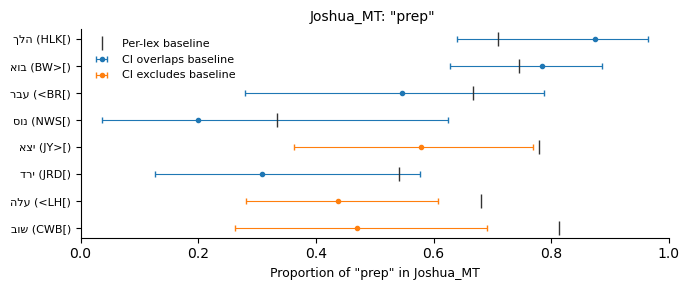

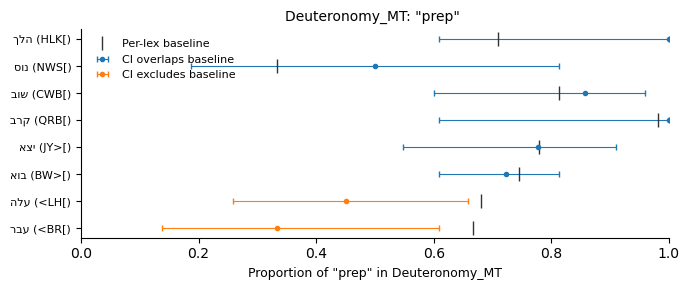

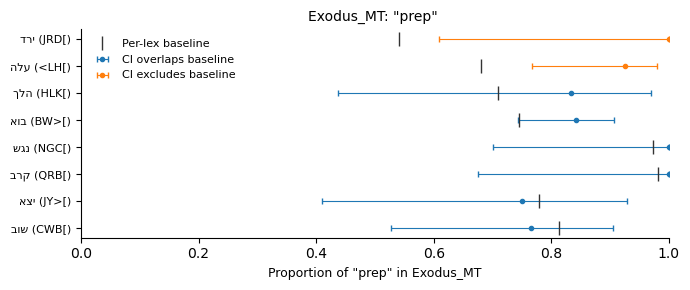

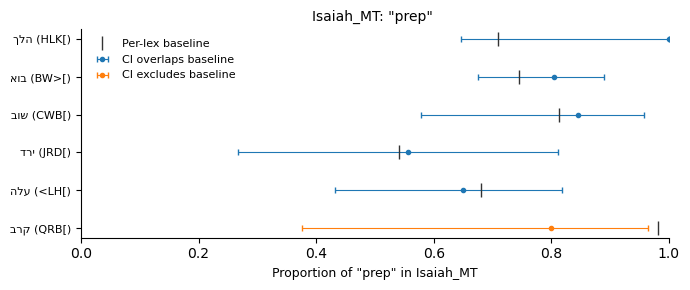

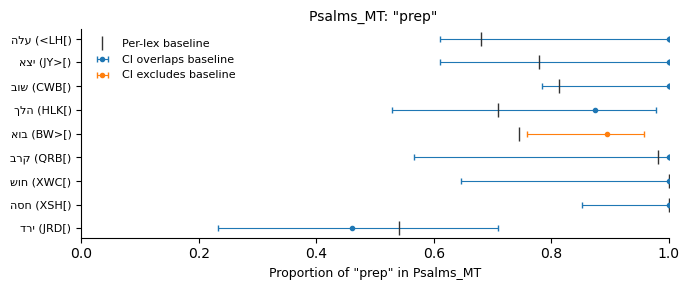

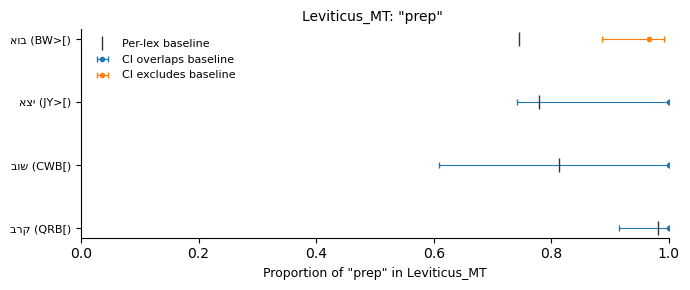

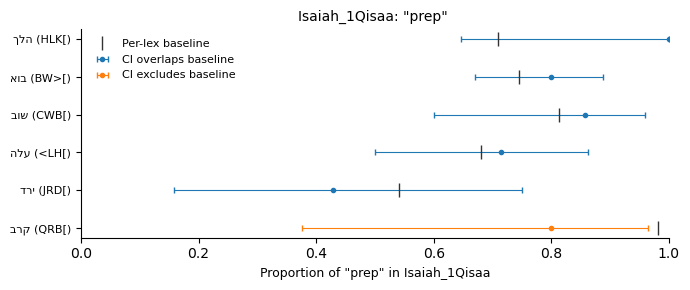

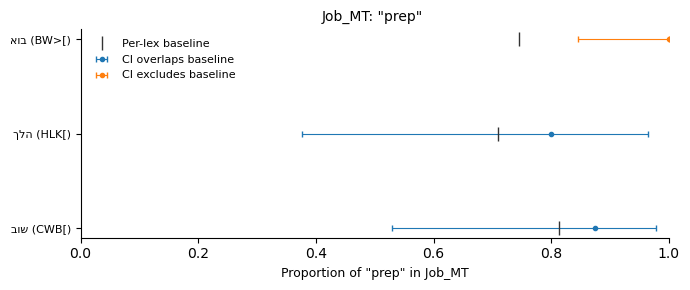

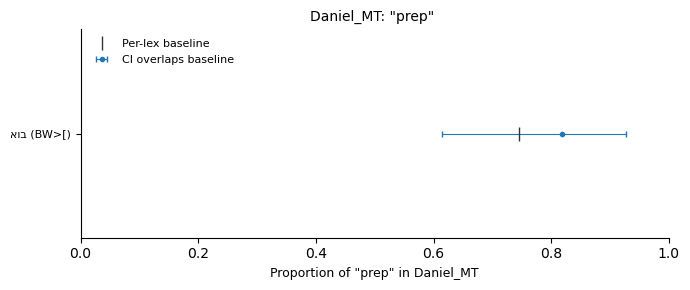

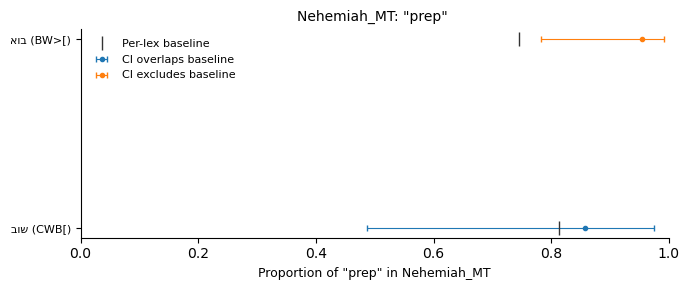

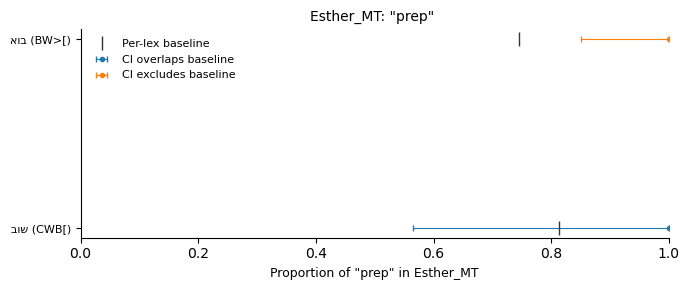

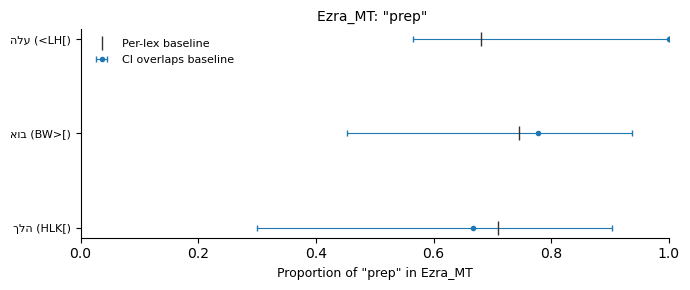

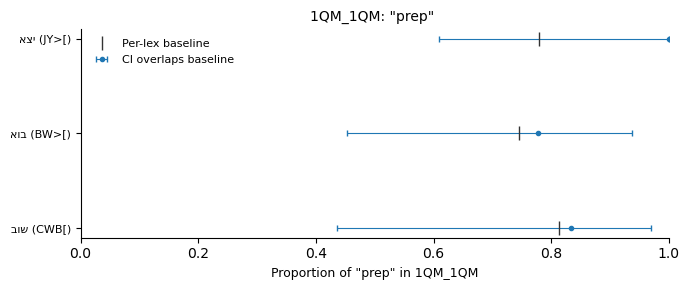

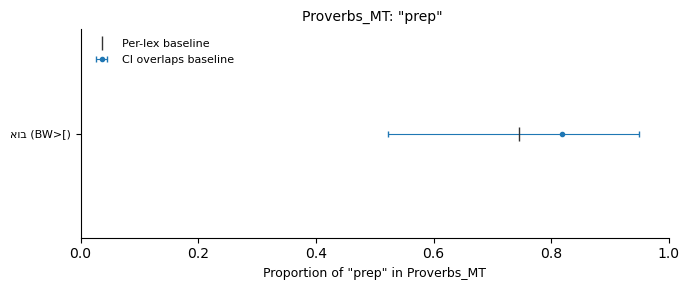

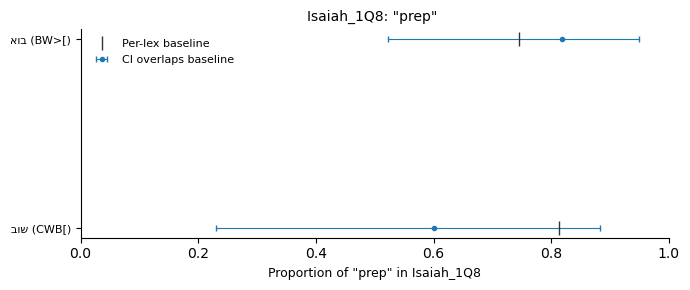

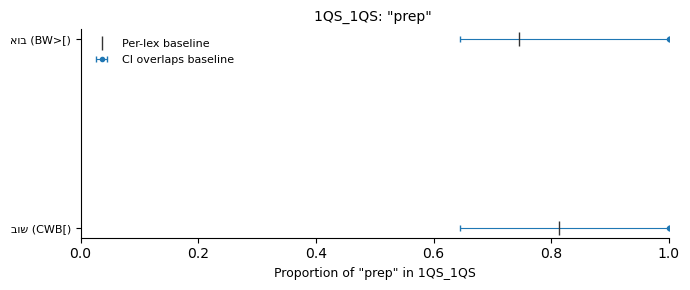

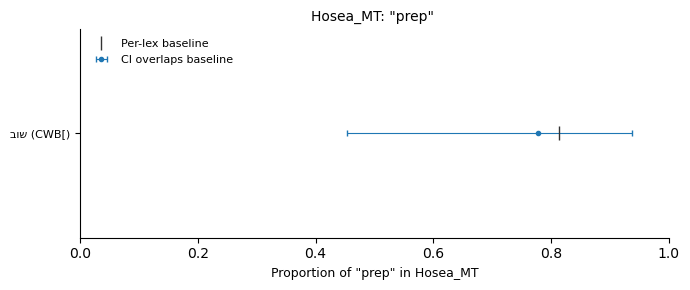

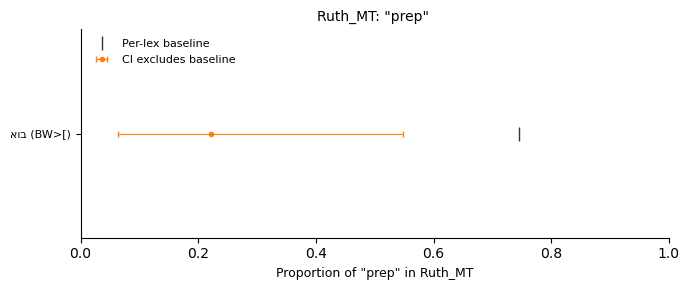

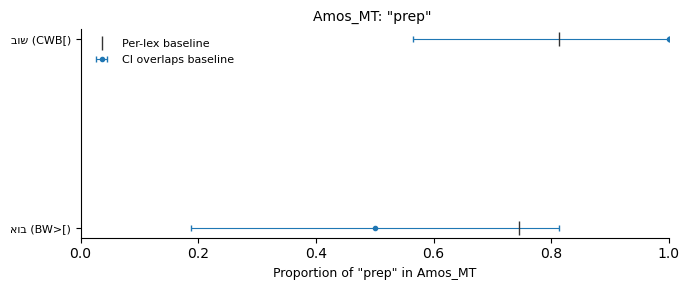

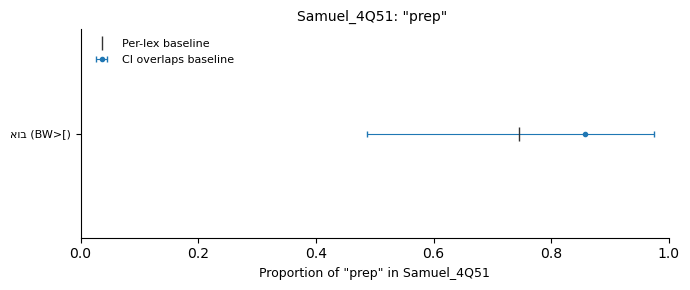

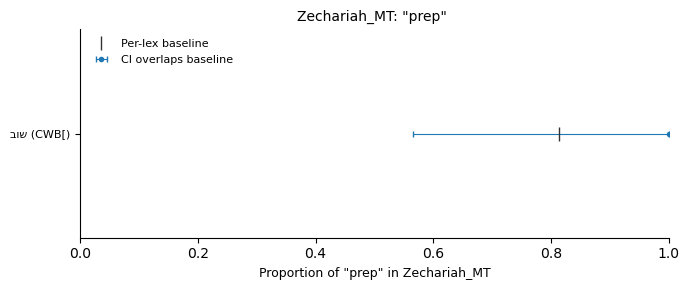

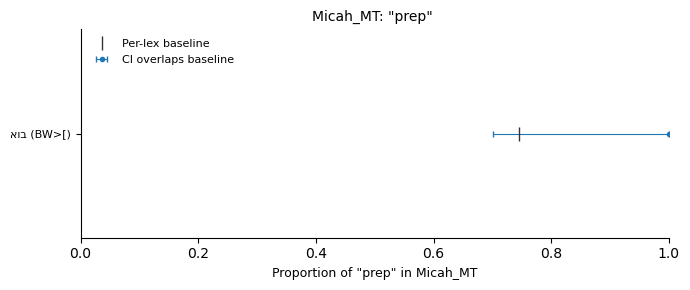

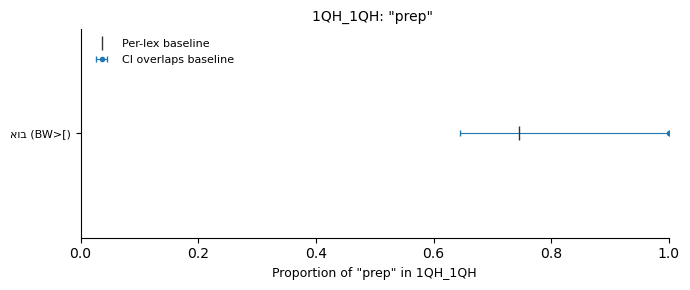

[skip] Jonah_MT: no lex with ≥5 tokens
[skip] Lamentations_MT: no lex with ≥5 tokens


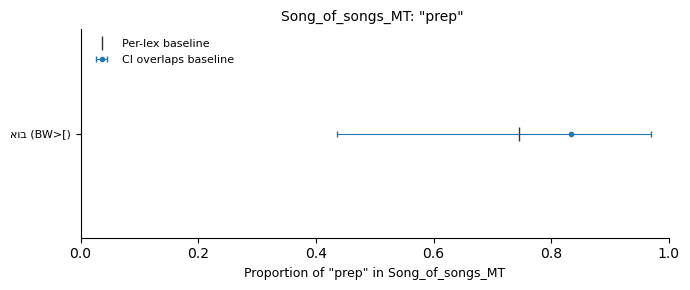

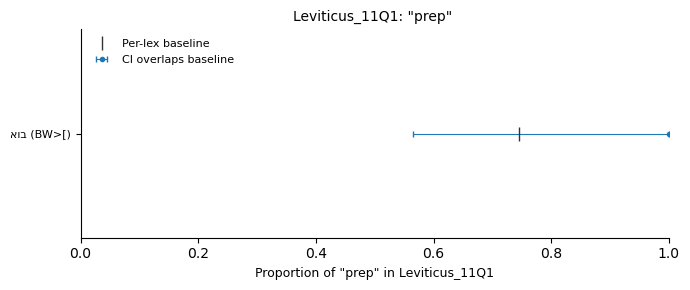

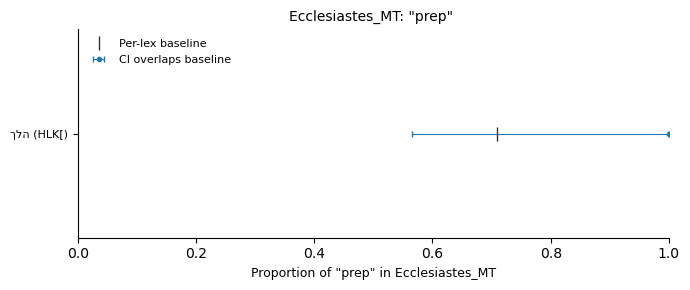

[skip] Joel_MT: no lex with ≥5 tokens
[skip] Numbers_4Q27: no lex with ≥5 tokens
[skip] Jonah_Mur88: no lex with ≥5 tokens
[skip] Malachi_MT: no lex with ≥5 tokens
[skip] Exodus_4Q22: no lex with ≥5 tokens
[skip] Leviticus_4Q24: no lex with ≥5 tokens
[skip] Obadiah_MT: no lex with ≥5 tokens
[skip] Genesis_4Q1: no lex with ≥5 tokens
[skip] Psalms_4Q83: no lex with ≥5 tokens
[skip] Deuteronomy_8Q3: no lex with ≥5 tokens
[skip] Obadiah_Mur88: no lex with ≥5 tokens
[skip] Deuteronomy_4Q41: no lex with ≥5 tokens
[skip] Deuteronomy_4Q138: no lex with ≥5 tokens
[skip] Haggai_MT: no lex with ≥5 tokens


In [51]:
# -------------------- config --------------------
construction = "prep"   # e.g., "dir-he", "prep", etc.
legend_alignment = "upper left"
MIN_N = 5                 # minimum # tokens of a lex within a given book to include
Z = 1.96                  # 95% Wilson intervals
ROW_HEIGHT = 0.20         # smaller => tighter rows
TOP_K_BOOKS = 50          # number of book_scroll to plot
SAVE_FIGS = True         # set True to save all figures
SAVE_PREFIX = f"visualizations/top50_books_forest/plot_forest_top{TOP_K_BOOKS}_books_{construction}"

# -------------------- helpers --------------------
def wilson_ci(p, n, z=1.96):
    n = np.asarray(n, dtype=float)
    p = np.asarray(p, dtype=float)
    den = 1.0 + (z**2)/n
    center = (p + (z**2)/(2*n)) / den
    half = (z * np.sqrt((p*(1-p))/n + (z**2)/(4*n**2))) / den
    lo = np.clip(center - half, 0, 1)
    hi = np.clip(center + half, 0, 1)
    return lo, hi

def make_xerr(xvals, lo_vals, hi_vals):
    low  = np.nan_to_num(np.clip(xvals - lo_vals, 0, None), nan=0.0)
    high = np.nan_to_num(np.clip(hi_vals - xvals, 0, None), nan=0.0)
    return np.vstack([low, high])

def lex_label(lex):
    heb = lex_to_hebrew.get(lex, lex)[::-1]
    return f"{heb} ({lex})"

# -------------------- precompute per-lex baseline across ALL books --------------------
# p0(lex) = mean of 1{cmpl_constr == construction} over all tokens of that lex in the whole corpus
baseline_per_lex = (
    (dfx["cmpl_constr"] == construction)
    .astype(float)
    .groupby(dfx["lex"])
    .mean()
    .rename("p0")
)

# -------------------- choose top-K books by total tokens --------------------
book_sizes = dfx.groupby("book_scroll").size().sort_values(ascending=False)
top_books = book_sizes.head(TOP_K_BOOKS).index.tolist()
if len(top_books) == 0:
    raise ValueError("No books found in dfx['book_scroll'].")

# -------------------- main loop: one figure per book --------------------
for book in top_books:
    df_b = dfx[dfx["book_scroll"] == book].copy()
    if df_b.empty:
        continue  # safety

    # totals per lex within this book
    totals = df_b.groupby("lex").size().rename("n_total")

    # keep only lex with >= MIN_N tokens in this book
    valid_lex = totals[totals >= MIN_N].index
    if len(valid_lex) == 0:
        # skip plotting if nothing passes the threshold
        print(f"[skip] {book}: no lex with ≥{MIN_N} tokens")
        continue

    # counts of the construction within this book per lex
    k = (
        df_b[df_b["cmpl_constr"] == construction]
        .groupby("lex").size().rename("k")
    )

    # assemble
    gb = (
        pd.DataFrame({"n_total": totals})
        .loc[valid_lex]
        .join(k, how="left")
        .fillna({"k": 0})
    )
    gb["k"] = gb["k"].astype(int)
    gb["p"] = gb["k"] / gb["n_total"].replace(0, 1)

    # join the global per-lex baseline
    gb = gb.join(baseline_per_lex, how="left")
    gb["p0"] = gb["p0"].fillna(0.0)

    # Wilson CIs for book-level estimates
    lo, hi = wilson_ci(gb["p"].to_numpy(), gb["n_total"].to_numpy(), z=Z)
    gb["lo"], gb["hi"] = lo, hi

    # sort by deviation from baseline for readability
    gb["dev"] = gb["p"] - gb["p0"]
    gb = gb.sort_values("dev", ascending=True)

    # labels
    gb["label"] = [lex_label(lex) for lex in gb.index]

    # -------------------- plotting (with significance coloring) --------------------
    fig_h = max(3.0, ROW_HEIGHT * len(gb) + 0.6)
    fig, ax = plt.subplots(figsize=(7, fig_h))

    y = np.arange(len(gb))
    x = gb["p"].to_numpy()
    lo = gb["lo"].to_numpy()
    hi = gb["hi"].to_numpy()
    p0 = gb["p0"].to_numpy()

    sig_mask = (hi < p0) | (lo > p0)
    nonsig_mask = ~sig_mask

    # non-significant
    if np.any(nonsig_mask):
        xerr_ns = make_xerr(x[nonsig_mask], lo[nonsig_mask], hi[nonsig_mask])
        ax.errorbar(
            x[nonsig_mask], y[nonsig_mask],
            xerr=xerr_ns,
            fmt="o", capsize=2, markersize=3, linewidth=0.8,
            label="CI overlaps baseline", color="C0", ecolor="C0"
        )

    # significant
    if np.any(sig_mask):
        xerr_s = make_xerr(x[sig_mask], lo[sig_mask], hi[sig_mask])
        ax.errorbar(
            x[sig_mask], y[sig_mask],
            xerr=xerr_s,
            fmt="o", capsize=2, markersize=3, linewidth=0.8,
            label="CI excludes baseline", color="C1", ecolor="C1"
        )

    # per-lex baseline markers at each row
    ax.plot(p0, y, "|", markersize=10, color="0.2", label="Per-lex baseline")

    # cosmetics
    ax.set_yticks(y)
    ax.set_yticklabels(gb["label"].tolist(), fontsize=8)
    ax.set_xlim(0, 1)
    ax.set_xlabel(f'Proportion of "{construction}" in {book}', fontsize=9)
    ax.set_title(
        f'{book}: "{construction}" ',
        fontsize=10, pad=6
    )

    # tidy legend (avoid duplicates)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc=legend_alignment, frameon=False, fontsize=8)

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    plt.tight_layout()

    if SAVE_FIGS:
        safe_book = str(book).replace("/", "_")
        plt.savefig(f"{SAVE_PREFIX}__{safe_book}.png", dpi=300, bbox_inches="tight")

    plt.show()

In [54]:
# README

read_me = "top20 book_scrolls, all verbs present in the dataset. To have a plot, a book_scroll need to have at least 5 tokens of a verb."

file_path = "visualizations/top20_books_forest/readme.txt"  # saves in the same folder as your notebook

with open(file_path, "w", encoding="utf-8") as f:
    f.write(read_me)